In [1]:
from keras.models import Sequential,Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding,GRU,TimeDistributed,RepeatVector,Merge,BatchNormalization,Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Embedding,GRU,TimeDistributed,RepeatVector,Merge,Input,merge,UpSampling2D
from keras.preprocessing import sequence
from keras import callbacks
from keras.optimizers import SGD, RMSprop, Adam

import numpy as np
from vgg16 import Vgg16
import matplotlib.pyplot as plt
import PIL.Image

from tqdm import tqdm

from utils import *

import cPickle as pickle
import string

import collections
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import re
from numpy.random import random, permutation, randn, normal 

import os

import preprocessing as preproc


Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5110)
/opt/conda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
def search_images_by(searched_word,images,predicted_captions):
    lmtzr = WordNetLemmatizer()
    lemm_word = lmtzr.lemmatize(searched_word)
    
    found_indexes = []
    for index,caption in enumerate(predicted_captions):
        lemm_caption_words = [lmtzr.lemmatize(word) for word in caption.split()]
        if lemm_word in lemm_caption_words:
            found_indexes.append(index)
    
    return ([images[i] for i in found_indexes],[predicted_captions[i] for i in found_indexes])

    
def make_prediction(random_number,images_concat_t,vgg_model):
    startIndex = word2index["START"]
    start_captions = [[startIndex]]
    start_captions = sequence.pad_sequences(start_captions, maxlen=MAX_CAPTION_LEN,padding='post')

    firstImage = np.expand_dims(images_concat_t[random_number], axis=0)
    first_image_vgg_features = vgg_model.predict(firstImage)
    first_image_input = np.squeeze(first_image_vgg_features)[0].reshape(1,4096)
    
    firstCaption = np.expand_dims(start_captions[0], axis=0) 
    prev_word_indexed_captions = np.expand_dims(list(start_captions[0]), axis=0)
    
    outputs = []

    endGenerated = False
    i = 0
        
    while ((not endGenerated) & (i < MAX_CAPTION_LEN-1)):
       
        predictions = model.predict([first_image_input, firstCaption, prev_word_indexed_captions])
        predictions = predictions[0]
        
        currentPred = predictions[i]
        
        max_index = np.argmax(currentPred)
        
        outputs.append(max_index)
        firstCaption[0,i+1] = max_index
        
        prev_word_indexed_captions[0,i+1] = firstCaption[0,i]
                
        i+=1

        if(index2word[max_index] == "END"):
            endGenerated = True

    caption = ' '.join([index2word[x] for x in firstCaption[0][:i+1]])

    drawImage = firstImage[0]
    drawImageT = np.transpose(drawImage,(1,2,0))
    plt.imshow(drawImageT)
    
    return (drawImageT,caption)

def make_prediction_on_dataset(images_concat_t, window_start = None, no_images = None):
    
    if(window_start == None):
        window_start = 0
        
    if(no_images == None):
        no_images = len(images_concat_t)
    
    vgg_model = get_vgg_model()
    
    images2Captions = [make_prediction(i,images_concat_t,vgg_model) for i in tqdm(range(window_start,window_start+no_images))]
    images = [image2Caption[0] for image2Caption in images2Captions]
    predicted_captions = [image2Caption[1] for image2Caption in images2Captions]

    
    return (images,predicted_captions)
        
def get_test_data(img_vgg_path,indexed_captions_path,future_words_path,):
    img_vgg_elements = os.listdir(img_vgg_path)
    indexed_captions_elements = os.listdir(indexed_captions_path)
    future_words_elements = os.listdir(future_words_path)

    img_vgg_elements.sort()
    indexed_captions_elements.sort()
    future_words_elements.sort()

    nr_batches = 1

    for index in tqdm(range(nr_batches)):

        img_vgg_batch_list = []
        indexed_caption_batch_list = []
        future_words_batch_list = []

        img_vgg_el_name = img_vgg_elements[index]
        indexed_caption_name = indexed_captions_elements[index]
        future_words_el_name = future_words_elements[index]

        img_vgg = preproc.load_array(img_vgg_path+"/"+img_vgg_el_name)
        indexed_caption = preproc.load_array(indexed_captions_path+"/"+indexed_caption_name)
        future_words = preproc.load_array(future_words_path+"/"+future_words_el_name)

        img_vgg_batch_list.append(img_vgg)
        indexed_caption_batch_list.append(indexed_caption)
        future_words_batch_list.append(future_words)

    img_vgg_big = np.vstack(img_vgg_batch_list)
    indexed_caption_big = np.vstack(indexed_caption_batch_list)
    future_words_big = np.vstack(future_words_batch_list)

    print(img_vgg_big.shape)
    print(indexed_caption_big.shape)
    print(future_words_big.shape)

    return img_vgg_big, indexed_caption_big, future_words_big

def generate_arrays_from_file(img_vgg_path,indexed_captions_path,future_words_path,current_words_path):
    while 1:
        img_vgg_elements = os.listdir(img_vgg_path)
        indexed_captions_elements = os.listdir(indexed_captions_path)
        future_words_elements = os.listdir(future_words_path)
        current_words_elements = os.listdir(current_words_path)
        
        img_vgg_elements.sort()
        indexed_captions_elements.sort()
        future_words_elements.sort()
        current_words_elements.sort()

        nr_elem = len(img_vgg_elements)
        
        BATCH_SIZE = 1
        
        for index in range(nr_elem/BATCH_SIZE):
            
            img_vgg_batch_list = []
            indexed_caption_batch_list = []
            future_words_batch_list = []
            current_words_batch_list = []
            
            for elem_in_batch in range(BATCH_SIZE):
                
                img_vgg_el_name = img_vgg_elements[index*BATCH_SIZE + elem_in_batch]
                indexed_caption_name = indexed_captions_elements[index*BATCH_SIZE + elem_in_batch]
                future_words_el_name = future_words_elements[index*BATCH_SIZE + elem_in_batch]
                current_words_el_name = current_words_elements[index*BATCH_SIZE + elem_in_batch]

                img_vgg = preproc.load_array(img_vgg_path+"/"+img_vgg_el_name)
                indexed_caption = preproc.load_array(indexed_captions_path+"/"+indexed_caption_name)
                future_words = preproc.load_array(future_words_path+"/"+future_words_el_name)
                current_words = preproc.load_array(current_words_path+"/"+current_words_el_name)
                
                img_vgg_batch_list.append(img_vgg)
                indexed_caption_batch_list.append(indexed_caption)
                future_words_batch_list.append(future_words)
                current_words_batch_list.append(current_words)
                
            img_vgg_big = np.vstack(img_vgg_batch_list)
            indexed_caption_big = np.vstack(indexed_caption_batch_list)
            future_words_big = np.vstack(future_words_batch_list)
            current_words_big = np.vstack(current_words_batch_list)
            
#             print(img_vgg_big.shape)
#             print(indexed_caption_big.shape)
#             print(future_words_big.shape)
    
            yield ([img_vgg_big,indexed_caption_big,current_words_big], future_words_big)


In [3]:
base_path = app_3_length_15_data_path

train_path = base_path + train_folder
val_path = base_path + val_folder

NR_TRAIN_EXAMPLES = 62735
NR_TEST_EXAMPLES = 28858
SMALL_NR_TEST_EXAMPLES = 1000

# Read Serialized Data - Images

In [4]:
test_images_concat_t = preproc.get_images_concat(val_path + images_concat_folder+ 'images_concat.bc',SMALL_NR_TEST_EXAMPLES)
print(test_images_concat_t.shape)

(1000, 3, 224, 224)


# Load precomputed misc data structures

In [5]:

train_img_vgg_path = base_path + train_folder + batch_folder + images_vgg_4096_folder
train_indexed_captions_path = base_path + train_folder + batch_folder + indexed_captions_folder
train_raw_captions_path = base_path + train_folder + batch_folder + captions_folder
train_future_words_path = base_path + train_folder + batch_folder + indexed_future_words_folder

test_img_vgg_path = base_path + val_folder + batch_folder +images_vgg_4096_folder
test_indexed_captions_path = base_path + val_folder + batch_folder + indexed_captions_folder
test_raw_captions_path = base_path + val_folder + batch_folder+captions_folder
test_future_words_path = base_path + val_folder + batch_folder+indexed_future_words_folder

indexed_prev_captions_folder = "indexed-prev-captions/"
train_prev_captions_path = base_path + train_folder + batch_folder + indexed_prev_captions_folder
test_prev_captions_path = base_path + val_folder + batch_folder + indexed_prev_captions_folder



In [6]:
unique_words = preproc.load_obj(base_path + general_datastruct_folder+"unique_words")
word2index = preproc.load_obj(base_path+general_datastruct_folder+"word2index")
index2word = preproc.load_obj(base_path+general_datastruct_folder+"index2word")

(train_captions_raw,_) = preproc.get_captions_raw_and_indexed(train_raw_captions_path,train_indexed_captions_path)
(test_captions_raw,_) = preproc.get_captions_raw_and_indexed(test_raw_captions_path,test_indexed_captions_path)


100%|██████████| 14/14 [00:00<00:00, 48.21it/s]


In [7]:
VOCAB_SIZE = len(unique_words)
MAX_CAPTION_LEN = 15 # ATENTIE AICI

In [8]:
print("MAX_CAPTION_LEN = %s"%MAX_CAPTION_LEN)
print("VOCAB_SIZE = %s"%VOCAB_SIZE)


MAX_CAPTION_LEN = 15
VOCAB_SIZE = 7275


# Word Embeddings

In [9]:
EMB_SIZE = 200
vecs, words, wordidx = preproc.load_vectors(save_path+glove_folder+"6B."+str(EMB_SIZE)+"d")

emb = preproc.create_emb(vecs, words, wordidx,index2word,VOCAB_SIZE)

Found = 7025
Not found = 249


# Model Building

In [10]:
# VGG

def get_vgg_model():
    image_model = Vgg16().model
    image_model.pop()
    image_model.pop()
    image_model.trainable = False
    image_model.add(RepeatVector(MAX_CAPTION_LEN))
    return image_model

def get_precomputed_input_model():
    input_model = Sequential()
    input_model.add(RepeatVector(MAX_CAPTION_LEN,input_shape=(4096,)))
    return input_model

# GRU

def get_language_model(emb):
    language_model = Sequential()
    language_model.add(Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_CAPTION_LEN,weights=[emb]))
    Dropout(0.2)
    language_model.add(BatchNormalization())
    return language_model

def get_reinforcement_model():
    reinforcement_model = Sequential()
    reinforcement_model.add(Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_CAPTION_LEN,weights=[emb]))
    Dropout(0.2)
    reinforcement_model.add(BatchNormalization())
    return reinforcement_model

# Top level model

def build_model(image_model,language_model,reinforcement_model):
    model = Sequential()
    model.add(Merge([image_model, language_model,reinforcement_model], mode='concat'))
    model.add(GRU(1024, return_sequences=True))
    model.add(TimeDistributed(Dense(VOCAB_SIZE, activation = 'softmax')))

    model.compile(loss='categorical_crossentropy', optimizer = Adam(0.001))
    return model


In [11]:
image_model = get_precomputed_input_model()
language_model = get_language_model(emb)
reinforcement_model = get_reinforcement_model()
model = build_model(image_model,language_model,reinforcement_model)

# Training the model

In [ ]:
# test_img_vgg, test_indexed_captions, test_future_words = get_test_data(test_img_vgg_path,
#                                                                        test_indexed_captions_path,
#                                                                        test_future_words_path)

In [ ]:
history = model.fit_generator(
                    generate_arrays_from_file(train_img_vgg_path,train_indexed_captions_path,
                                              train_future_words_path,train_prev_captions_path),
                    samples_per_epoch=82000,
                    nb_epoch=10
#                     validation_data = ([test_img_vgg, test_indexed_captions], test_future_words),
#                     callbacks=[callbacks.RemoteMonitor()]
                   )

In [ ]:
preproc.plot_loss_from_history(history)

In [ ]:
model.evaluate_generator(generate_arrays_from_file(test_img_vgg_path,test_indexed_captions_path,
                                                   test_future_words_path,test_prev_captions_path),
                         val_samples = 2048)

In [ ]:
model.save_weights(save_path + models_folder +'app_3_length_15_past_word_65_epoch.h5')

In [12]:
# model.load_weights(save_path + models_folder +'app_3_length_15_30_epoch.h5')
model.load_weights(save_path + models_folder +'app_3_length_15_past_word_65_epoch.h5')

# Evaluate the model

In [ ]:
model.evaluate_generator(generate_arrays_from_file(train_img_vgg_path,
                                                   train_indexed_captions_path,
                                                   train_future_words_path,
                                                   train_prev_captions_path),
                        val_samples = NR_TRAIN_EXAMPLES)

In [ ]:
model.evaluate_generator(generate_arrays_from_file(test_img_vgg_path,
                                                   test_indexed_captions_path,
                                                   test_future_words_path,
                                                   test_prev_captions_path),
                        val_samples = NR_TEST_EXAMPLES)

In [ ]:
def make_test_predictions(test_images_concat_t):
    return make_prediction_on_dataset(test_images_concat_t,0,NR_TEST_EXAMPLES)

In [ ]:
(_,all_test_predictions) = make_test_predictions(test_images_concat_t)

In [ ]:
preproc.save_obj(all_test_predictions,val_path+"predictions/"+"app_3_length_15_past_word_65_epoch_predicted_captions")

# Testing the model

In [16]:
window_start = 512
nr_images = 400

# images_concat_t = train_images_concat_t
# real_captions = train_captions_raw

images_concat_t = test_images_concat_t
real_captions = test_captions_raw

(images,predicted_captions) = make_prediction_on_dataset(images_concat_t,window_start,nr_images)


 22%|██▏       | 86/400 [00:09<00:25, 12.53it/s]

100%|██████████| 400/400 [00:34<00:00, 12.94it/s]


In [ ]:
preproc.plot_predictions(images,titles = predicted_captions)

In [ ]:
common_words2app = preproc.most_common_words(predicted_captions,500)
common_words2app

In [17]:
searched_word = "plate"
(found_images,found_captions) = search_images_by(searched_word,images,predicted_captions)
print("Number of results = %d"%len(found_images))

Number of results = 19


In [ ]:
preproc.plot_predictions(found_images,found_captions)

# Semantic Segmentation

In [18]:
# def get_unet(img_rows, img_cols):
    
    
#     inputs = Input((3, img_rows, img_cols))


def get_unet(img_rows, img_cols):
    
    
    inputs = Input((3, img_rows, img_cols))
    bn = BatchNormalization()(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(bn)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

#     model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def normalize_imgs(data):
    
    data = data.astype('float32')

    mean = np.mean(data)  # mean for data centering
    std = np.std(data)  # std for data normalization

    data -= mean
    data /= std
    
    return data


In [19]:
transposed_img = np.transpose(found_images,(0,3,1,2))
transposed_img.shape

(19, 3, 224, 224)

In [21]:
seg_net_model = get_unet(224,224)
save_path = "/home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/detection/food2-dataset-4cls/models/"
seg_net_model.load_weights(save_path+"unet_3e_bn.h5")

In [22]:
predictions = seg_net_model.predict(transposed_img)
predictions.shape

(19, 1, 224, 224)

In [25]:
def plotImageCaptionToMask(predictions, images,titles):
  
    nr_rows = len(predictions)
    nr_cols = 2
    pic_index = 1
    
    figsize = 8
    plt.figure(figsize=(figsize,figsize))
    for index in range(nr_rows):
   
        raw_pred = predictions[index]
        squeezed_pred = np.squeeze(raw_pred)
        
        image = images[index]
        
        nr_cols = 2
        
        plt.subplot(1,nr_cols,1)
        plt.title(titles[index])
        plt.imshow(image)
        pic_index+=1
        
        
        plt.subplot(1,nr_cols,2)
        pic_index+=1
        plt.imshow(squeezed_pred)
        plt.imshow(image, alpha=0.5)
    
        
        plt.figure(figsize=(figsize,figsize))
        
    plt.show()

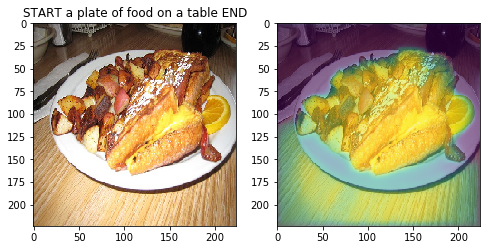

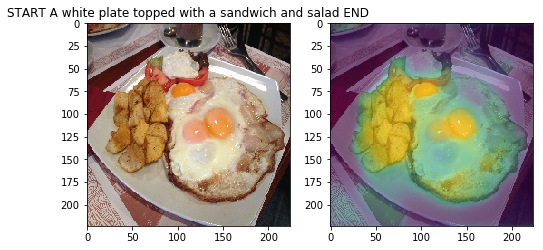

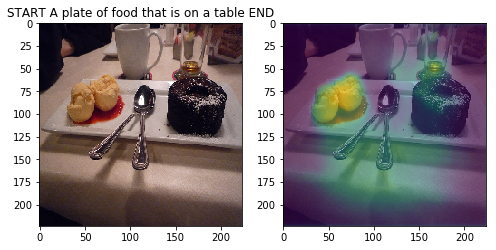

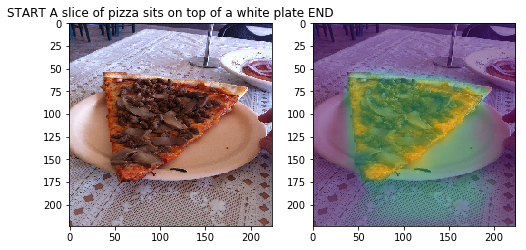

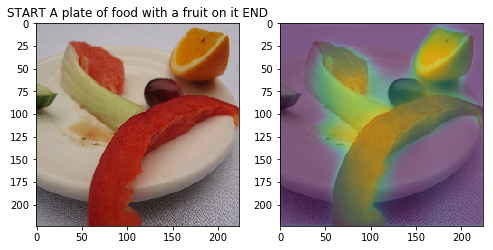

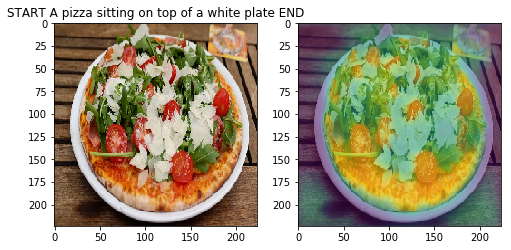

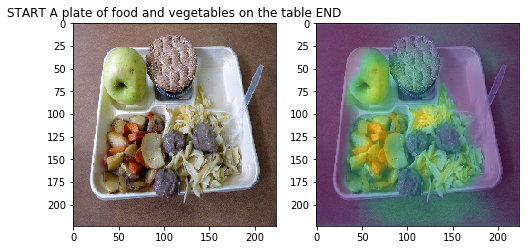

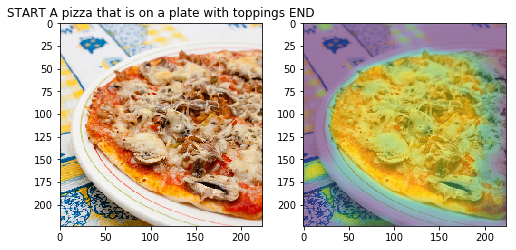

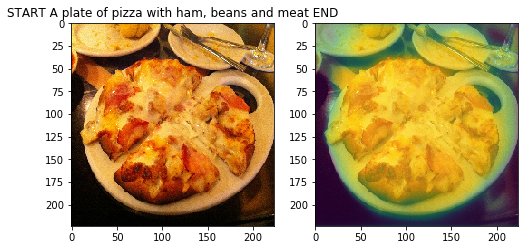

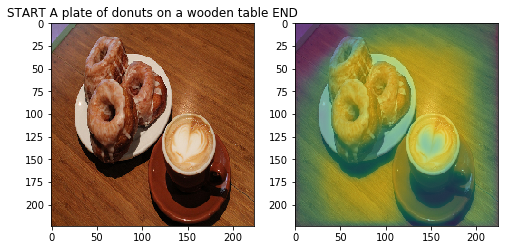

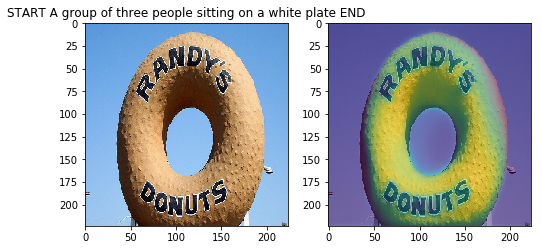

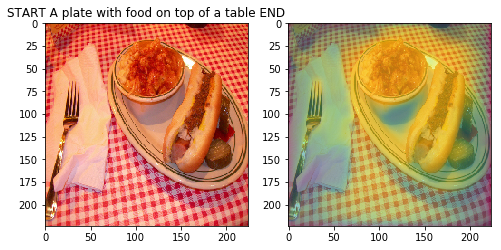

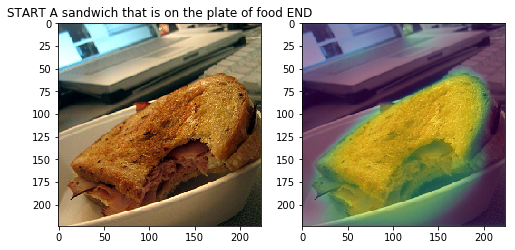

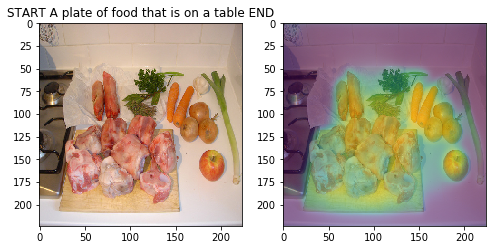

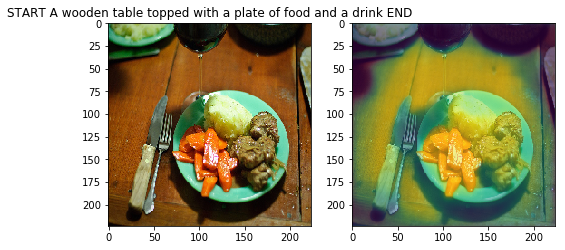

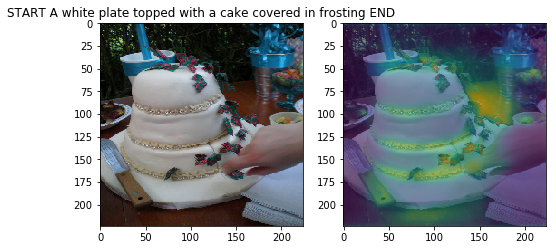

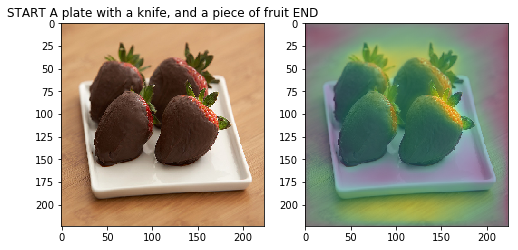

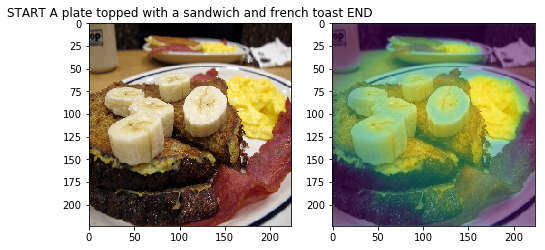

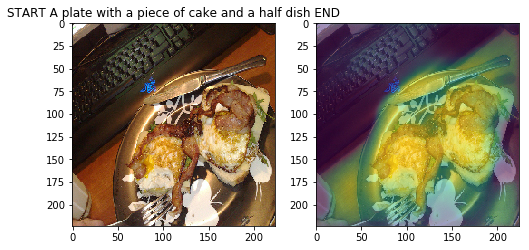

In [28]:
plotImageCaptionToMask(predictions, found_images, found_captions)

In [ ]:
for i in range(len(predictions)):
    pred_img = np.squeeze(predictions[i])

    orig_img = found_images[i]
    
    plt.imshow(pred_img)
    plt.imshow(orig_img, alpha=0.5)
    
    plt.figure()
plt.show()


In [ ]:
for prediction in predictions:
    plt.imshow(np.squeeze(prediction))
    plt.figure()
plt.show()

# Make predictions on misc dataset

In [ ]:
misc_images_path = save_path + misc_images_folder

In [ ]:
misc_images = []
for img_path in os.listdir(misc_images_path):
    img = PIL.Image.open(misc_images_path+img_path)
    img = img.resize((224, 224), PIL.Image.NEAREST)
    img = np.asarray(img)
    img = np.transpose(img,(2,0,1))
    img = np.expand_dims(img,axis=0)
    
    misc_images.append(img)
    
stacked_images = np.vstack(misc_images)

In [ ]:
(misc_images,misc_predicted_captions) = make_prediction_on_dataset(stacked_images)
preproc.plot_predictions(misc_images,misc_predicted_captions)